### Task: Calculate information content of all TFs and apply to known found TFs  in LTRs

In [1]:
from Bio import motifs
jaspar_file = "/home/xhorvat9/ltr-annotator/Diplomovka_Final/JASPAR_work/All_Profiles_JASPAR.jaspar"

with open(jaspar_file, "r") as jspr:
    TF_motifs = motifs.parse(jspr, "jaspar")

### Create lambda function to calculate the ics

In [2]:
import math
total_ic = lambda pwm: sum([
    sum([ 
        pwm[base_prob][position] * math.log2(pwm[base_prob][position]) 
        #for all possible bases
        for base_prob in pwm.keys() 
        if pwm[base_prob][position] > 0
    ]) - math.log2(0.25)
    # for each position in the motif
    for position in range(pwm.length)
    # the log was added to not discriminate long motifs too much
]) / math.log2(pwm.length)

### Apply to list of known motifs and select top 100

In [3]:
motif_ics = {TF_motif.name: total_ic(TF_motif.pwm) for TF_motif in TF_motifs}
top_100_ics_motifs = [tup[0] for tup in sorted(motif_ics.items(), key=lambda x: x[1], reverse=True)[:100]]

### Load the LTR motif dictionary and extract the top 100 motifs from each

In [ ]:
import pickle
LTR_motifs = pickle.load(open("/storage/brno2/home/xhorvat9/Diplomovka_DBs/JASPAR_Profiles/sequence_motifs.b", "rb"))

In [ ]:
extracted_motifs = {}
for seq in LTR_motifs:
    extracted_motifs[seq] = {motif: LTR_motifs[seq][motif] for motif in top_100_ics_motifs}

In [ ]:
pickle.dump(extracted_motifs, open("/storage/brno2/home/xhorvat9/ltr-annotator/Diplomovka_Final/JASPAR_work/sequence_motifs_top_100_ics.b", "wb"))

### Transform the dataframe and prepare it for ECLAT

In [1]:
import Bio.SeqIO as SeqIO
from Jaspar_parser import position_dict_to_occurence
import pickle
seq_names = [rec.id for rec in SeqIO.parse("/opt/xhorvat9_TE_DBs/CNN_BERT_train_DB/LTR_sequences.fasta", "fasta") ]
motifs = pickle.load(open("sequence_motifs_top_100_ics.b", "rb"))

motifs = {seq_name: motifs[seq_name] for seq_name in seq_names}
seq_motif_list = [position_dict_to_occurence(motifs[seq_name]) for seq_name in seq_names]

In [2]:
import pandas as pd
data = pd.DataFrame(seq_motif_list)

### Run ECLAT

In [4]:
from pyECLAT import ECLAT



ec = ECLAT(data, verbose=True)

rule_indices, rule_supports = ec.fit(min_support=0.1,
                                           min_combination=2,
                                           max_combination=3) # the maximum non Na entries in a row
pickle.dump([rule_indices, rule_supports], open("/storage/brno2/home/xhorvat9/ltr-annotator/Diplomovka_Final/JASPAR_work/ECLAT_results_list_max_3.b", "wb+"))


100%|██████████| 98/98 [00:00<00:00, 4497.96it/s]


Combination 2 by 2


2485it [00:08, 276.54it/s]


Combination 3 by 3


12523it [00:37, 341.73it/s]

In [17]:
from pyECLAT import ECLAT

ec = ECLAT(data, verbose=True)

rule_indices, rule_supports = ec.fit(min_support=0.1,
                                           min_combination=2,
                                           max_combination=4) # the maximum non Na entries in a row
pickle.dump([rule_indices, rule_supports], open("/opt/xhorvat9_TE_DBs/CNN_BERT_train_DB/ECLAT_results_list_max_4.b", "wb+"))


100%|██████████| 101/101 [00:00<00:00, 422.77it/s]


Combination 2 by 2


2701it [00:34, 78.81it/s] 


Combination 3 by 3


64824it [09:09, 117.99it/s]


Combination 4 by 4


1150626it [2:22:50, 134.26it/s]


In [1]:
import pickle 
import seaborn as sns

[rule_indices, rule_supports] = pickle.load(open("/opt/xhorvat9_TE_DBs/CNN_BERT_train_DB/ECLAT_results_list_max_4.b", "rb"))

In [ ]:
rule_supports

<AxesSubplot:>

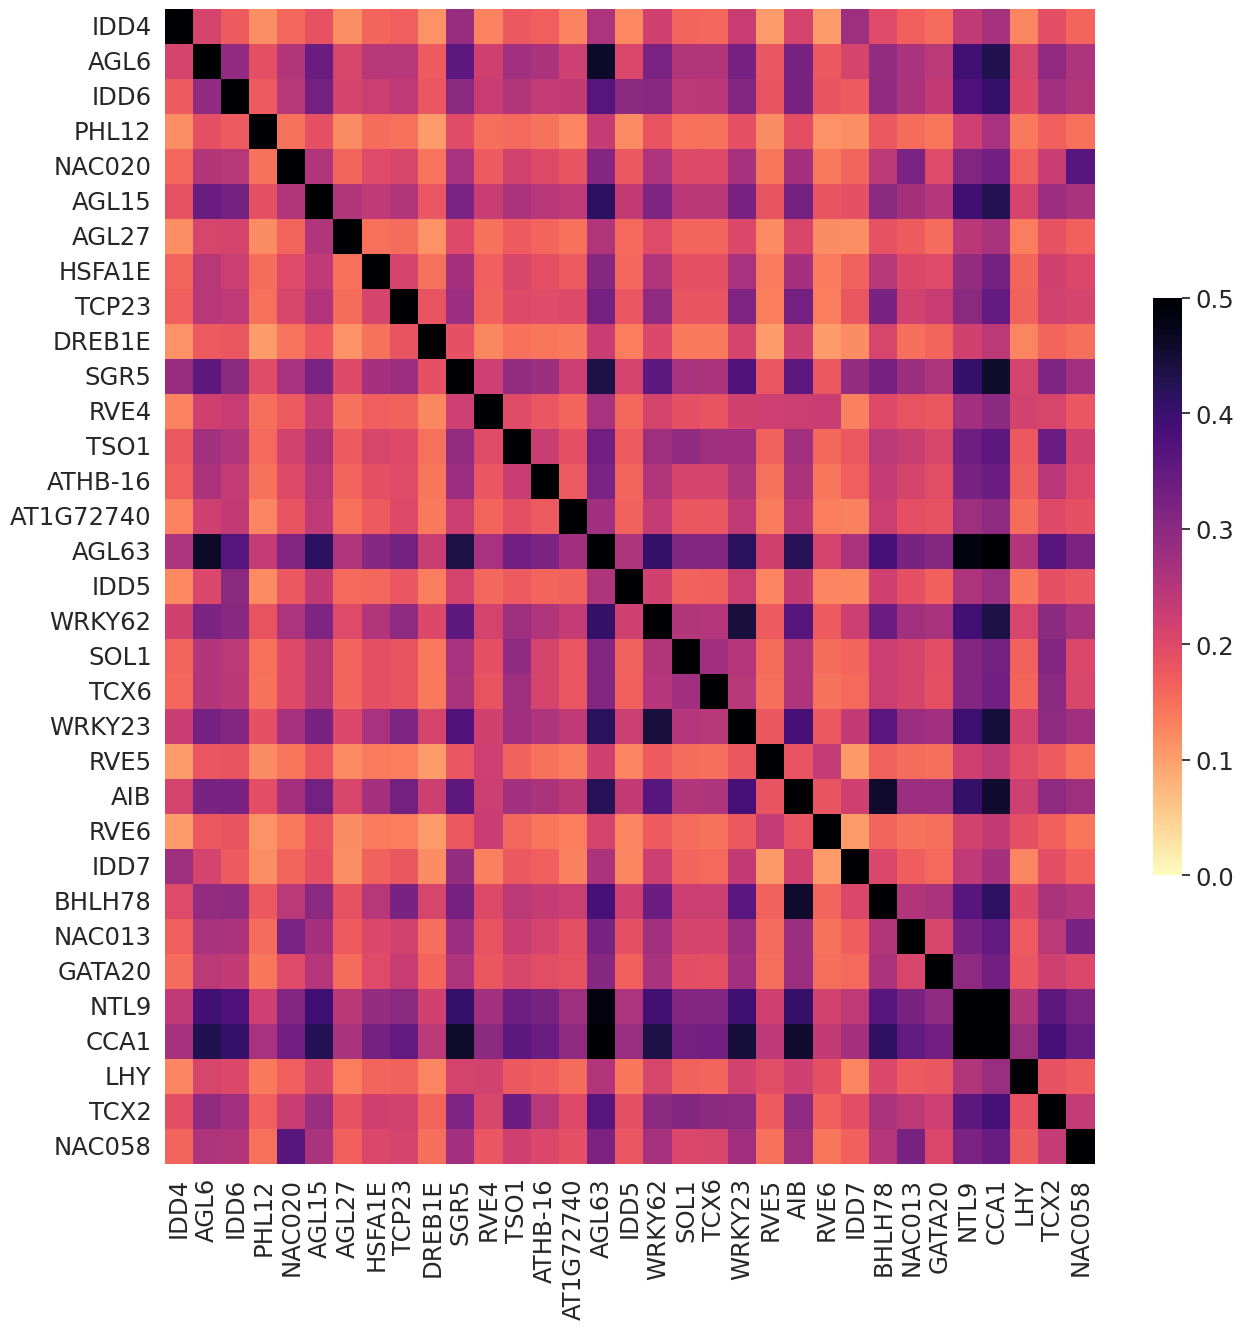

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


binary_rules = {key: rule_supports[key] for key in rule_supports if key.count("&") == 1}
unique_motifs = set([key.split(" & ")[0] for key in binary_rules] + [key.split(" & ")[1] for key in binary_rules])
exclude = ["OJ1058_F05.8","O2", "TCP4", "AGL55","ARALYDRAFT_493022","ARALYDRAFT_484486", "ARALYDRAFT_495258", "ARF13", "TCP17","ARF14","Os05g0497200", "BZIP11", "BHLH104", "TCP7", "RAMOSA1", "NAC011", "BZIP69", "TGA3", "BCP1", "TGA9", "WRKY70", "BZIP53", "WRKY7", "TCP5", "BZIP2", "BCP1", "ARALYDRAFT_496250", "MGP", "GATA11","RVE8",  "WRKY27",  "AGL13", "ATHB-20", "GAF1", "BPC1", "WRKY71"]#["BZIP44", "BZIP69", "RAMOSA1", "HSFA6A", "BZIP11", "BHLH104", "BZIP2", "MYB27", "WRKY70", "BZIP53", "TCP5", "GATA11", "TCP7", "GAF1", "WRKY7", "ARF13", "TGA3", "ATHB-20", "MGP"]
unique_motifs = {key1: {key2: 0 for key2 in unique_motifs if key2 not in exclude} for key1 in unique_motifs if key1 not in exclude}

for key in binary_rules:
    motif1, motif2 = key.split(" & ")
    if motif1 in exclude or motif2 in exclude:
        continue
    unique_motifs[motif1][motif2] = binary_rules[key]
    unique_motifs[motif2][motif1] = binary_rules[key]
for key in unique_motifs:
    unique_motifs[key][key] = 1
unique_motifs = pd.DataFrame(unique_motifs)
plt.figure(figsize=(15,15))

sns.set(font_scale=1.6)
sns.heatmap(unique_motifs, cmap="magma_r", vmin=0, vmax=0.5,cbar_kws={"orientation": "vertical", "shrink": 0.5})

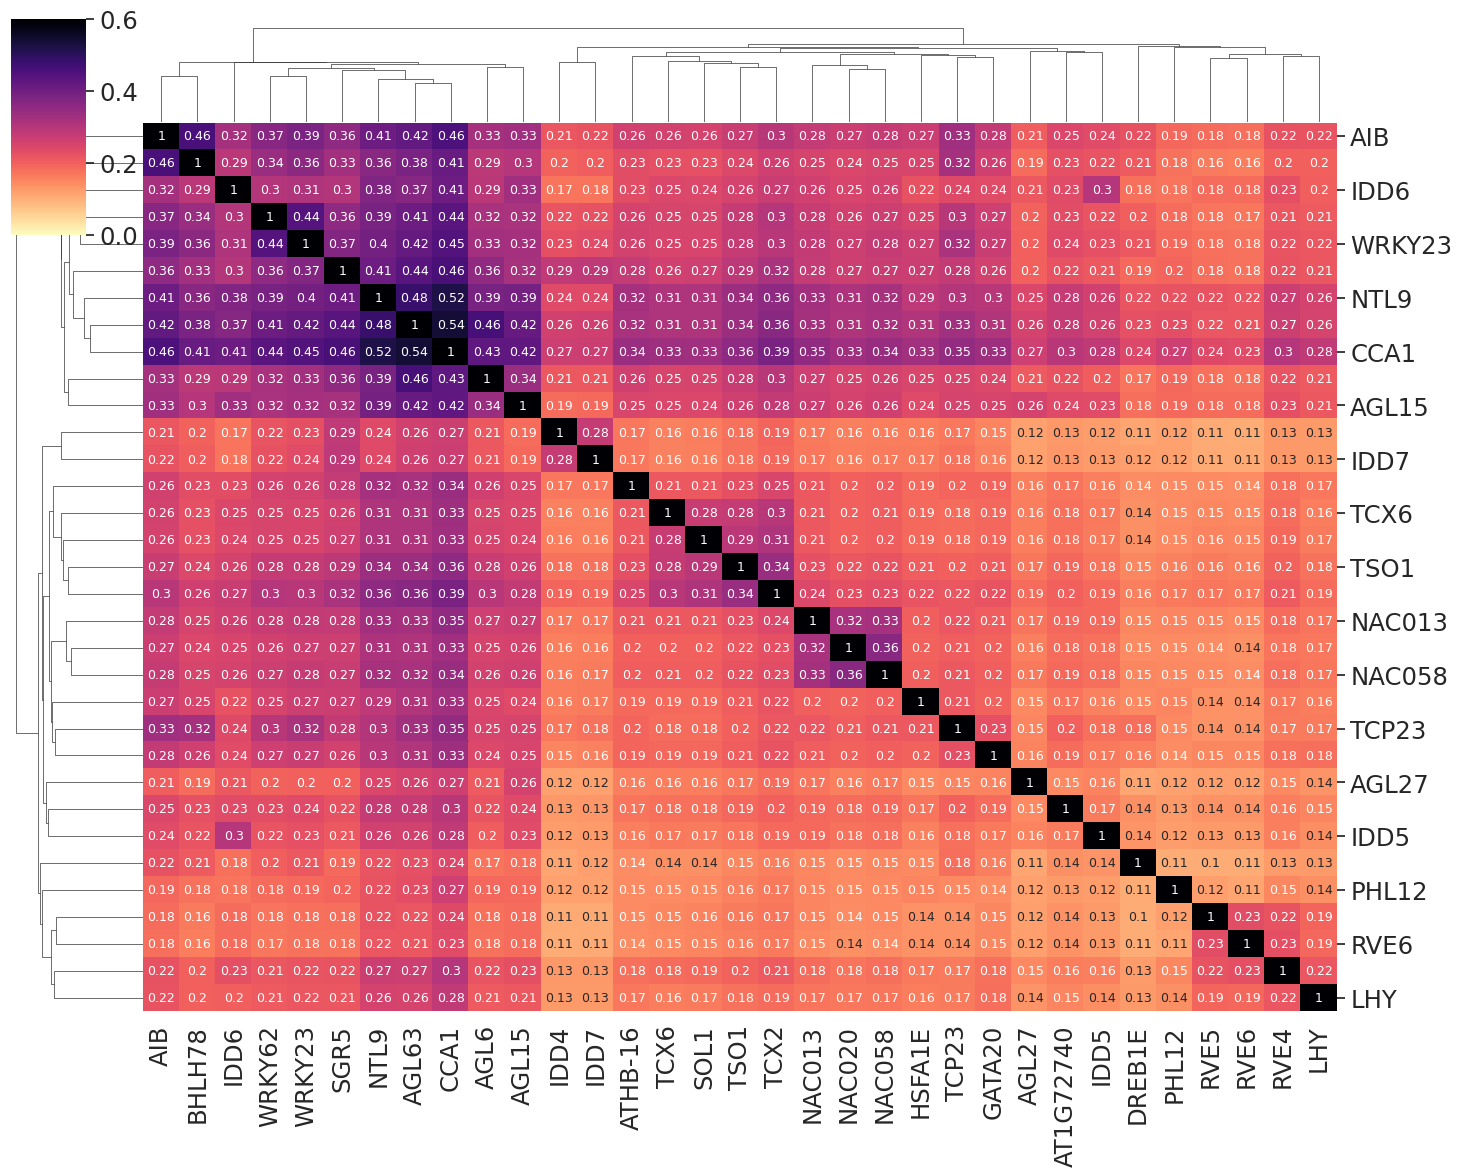

In [3]:
unique_motifs[[]]

sns.clustermap(unique_motifs, method="complete", cmap='magma_r', annot=True, 
               annot_kws={"size": 9}, vmin=0, vmax=0.6, figsize=(15,12),cbar_kws={"orientation": "vertical", "shrink": 0.2}, dendrogram_ratio=0.1);



In [4]:
short_unique = unique_motifs[["AIB", "BHLH78", "IDD6", "WRKY62", "WRKY23", "SGR5", "NTL9", "AGL63", "CCA1", "AGL6", "AGL15", "ATHB-16", "TCX6", "SOL1", "TSO1", "TCX2", "NAC013", "NAC020", "NAC058", "HSFA1E", "TCP23", "GATA20"]].loc[["AIB", "BHLH78", "IDD6", "WRKY62", "WRKY23", "SGR5", "NTL9", "AGL63", "CCA1", "AGL6", "AGL15", "ATHB-16", "TCX6", "SOL1", "TSO1", "TCX2", "NAC013", "NAC020", "NAC058", "HSFA1E", "TCP23", "GATA20"]].loc[["AIB", "BHLH78", "IDD6", "WRKY62", "WRKY23", "SGR5", "NTL9", "AGL63", "CCA1", "AGL6", "AGL15", "ATHB-16", "TCX6", "SOL1", "TSO1", "TCX2", "NAC013", "NAC020", "NAC058", "HSFA1E", "TCP23", "GATA20"]].loc[["AIB", "BHLH78", "IDD6", "WRKY62", "WRKY23", "SGR5", "NTL9", "AGL63", "CCA1", "AGL6", "AGL15", "ATHB-16", "TCX6", "SOL1", "TSO1", "TCX2", "NAC013", "NAC020", "NAC058", "HSFA1E", "TCP23", "GATA20"]]

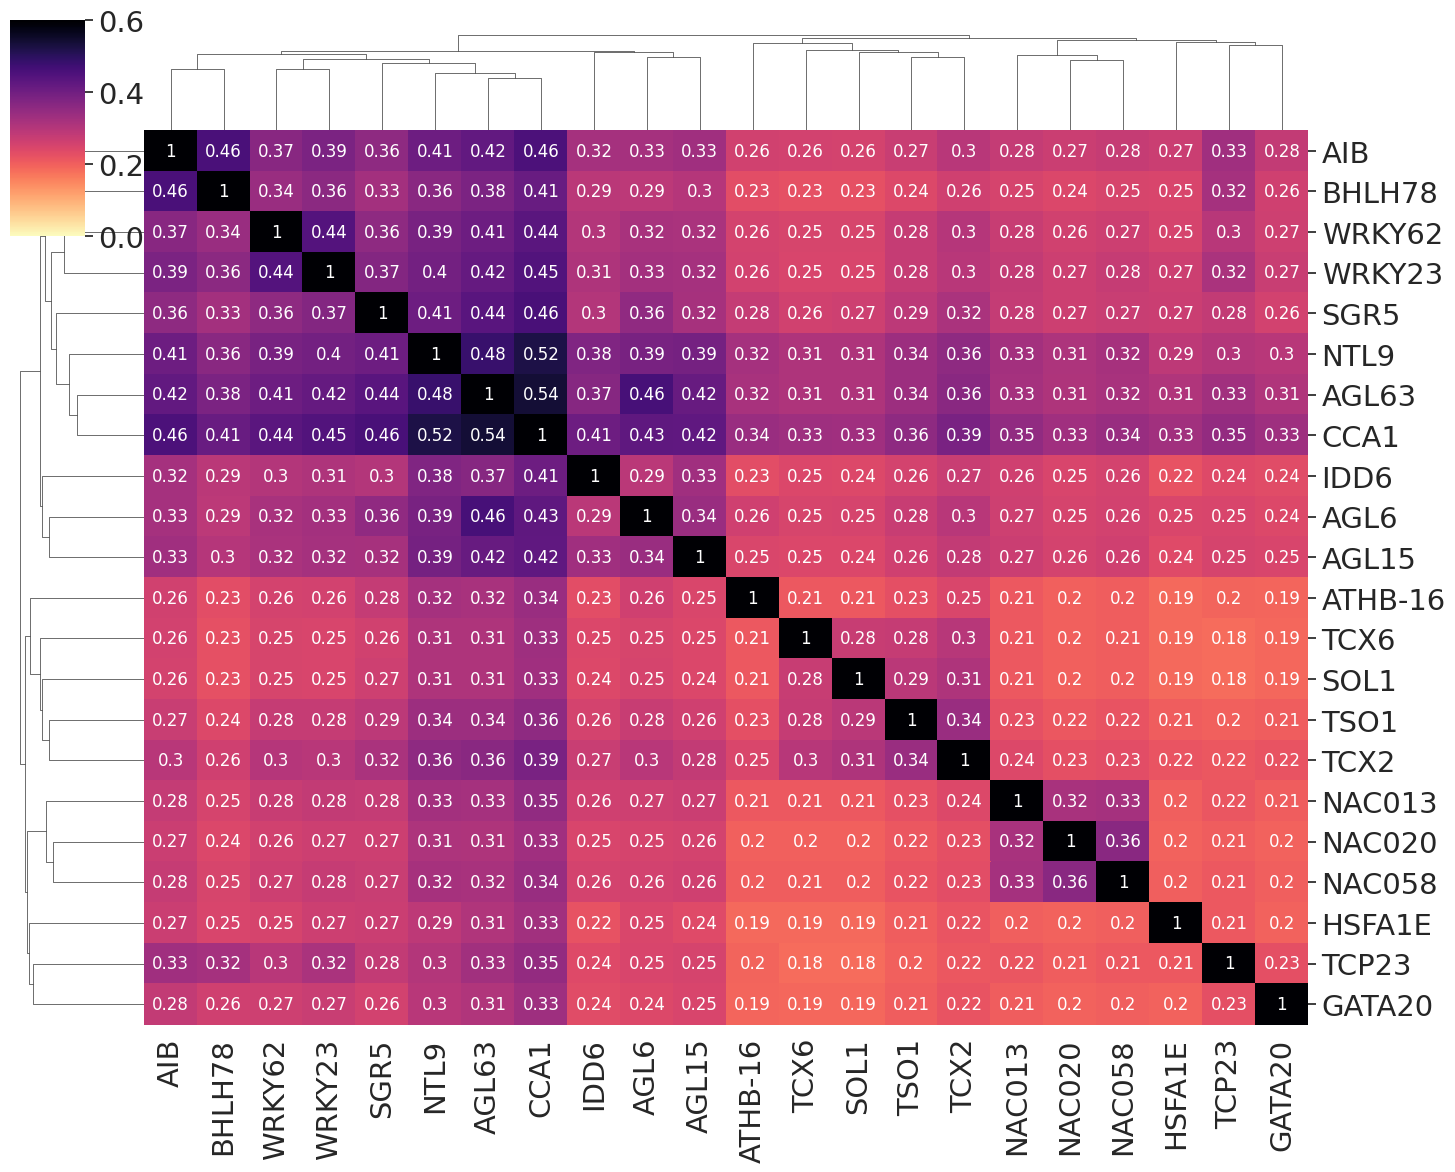

In [5]:
sns.set(font_scale=1.9)
sns.clustermap(short_unique, method="complete", cmap='magma_r', annot=True,
               annot_kws={"fontsize": 12}, vmin=0, vmax=0.6, figsize=(15,12),cbar_kws={"orientation": "vertical", "shrink": 0.9}, dendrogram_ratio=0.1);

In [ ]:

ternary_rules = {key: rule_supports[key] for key in rule_supports if key.count("&") == 2}
unique_motifs = set([key.split(" & ")[0] for key in binary_rules] + [key.split(" & ")[1] for key in binary_rules])
unique_motifs 

In [7]:
common_tripletslist = list(dict(sorted(ternary_rules.items(), key=lambda item: item[1])).keys())[-25:]
top_25 ={key: ternary_rules[key] for key in common_tripletslist}

In [8]:
d = pd.DataFrame({"Motifs": list(top_25.keys()), "Support": list(top_25.values())}).sort_values(by="Support", ascending=False)

### Define custom palette mimicking the one in the clustermap

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
cm = mpl.cm.get_cmap('magma_r')
cm(0.5)
norm = mpl.colors.Normalize(vmin=0.0, vmax=0.7)
custom_palette = sns.color_palette(cm([norm(val) for val in d["Support"]]), 25)

(0.709962, 0.212797, 0.477201, 1.0)

### Plot the size 4 and 3 itemsets on a grid together

In [16]:

quaternary_rules = {key: rule_supports[key] for key in rule_supports if key.count("&") == 3}

In [17]:
common_quadruples_list = list(dict(sorted(quaternary_rules.items(), key=lambda item: item[1])).keys())[-25:]
top_25 ={key: quaternary_rules[key] for key in common_quadruples_list}
d = pd.DataFrame({"Motifs": list(top_25.keys()), "Support": list(top_25.values())}).sort_values(by="Support", ascending=False)

/tmp/ipykernel_231799/992242649.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


(array([0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

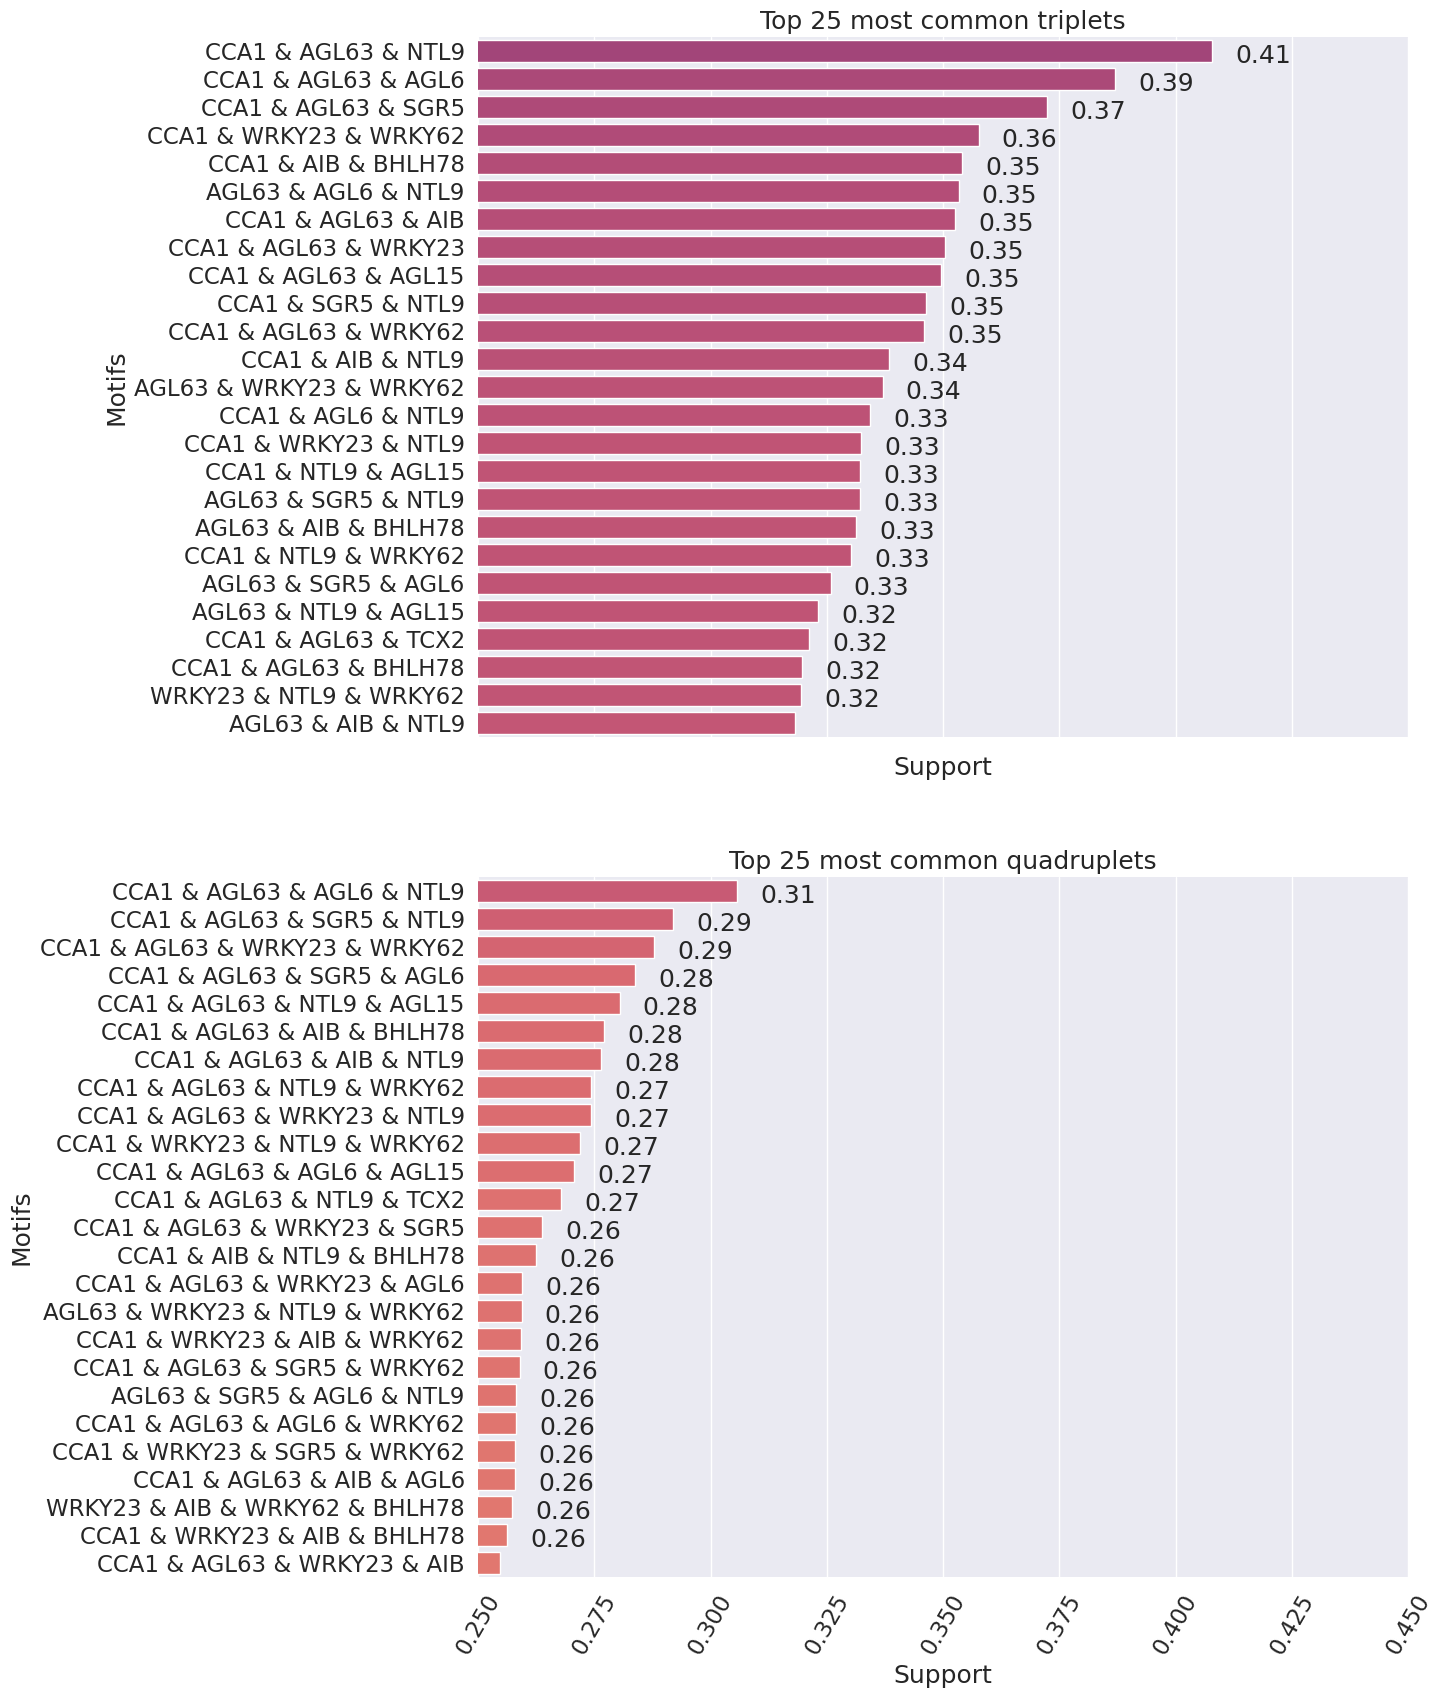

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, figsize=(12, 20))

norm = mpl.colors.Normalize(vmin=0.0, vmax=0.6)
custom_palette = sns.color_palette(cm([norm(val) for val in d["Support"]]), 25)
cmap = sns.color_palette(custom_palette, as_cmap=True)
common_tripletslist = list(dict(sorted(ternary_rules.items(), key=lambda item: item[1])).keys())[-25:]
top_25 ={key: ternary_rules[key] for key in common_tripletslist}
d = pd.DataFrame({"Motifs": list(top_25.keys()), "Support": list(top_25.values())}).sort_values(by="Support", ascending=False)
sns.set(rc={'figure.figsize':(20,11)}, font_scale=1.5)
plt.xticks(rotation=90)
cmap = sns.color_palette(custom_palette, as_cmap=True)
ax = sns.barplot(y = "Motifs", x="Support",data=d, palette=cmap, ax=axes[0])
sns.despine(left=True, bottom=True)
plt.xlim(0.25, 0.45)
axes[0].set_xlim(0.25, 0.45)
axes[0].title.set_text('Top 25 most common triplets')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
for p in axes[0].patches: 
    axes[0].annotate(format(p.get_width(), '.2f'),
( p.get_width()+0.005,p.get_y() + p.get_height() / 2+0.9),
ha = 'left', 
xytext = (0, 10),
textcoords = 'offset points')

norm = mpl.colors.Normalize(vmin=0.0, vmax=1)
custom_palette = sns.color_palette(cm([norm(val) for val in d["Support"]]), 25)
cmap = sns.color_palette(custom_palette, as_cmap=True)

quaternary_rules = {key: rule_supports[key] for key in rule_supports if key.count("&") == 3}
common_quadruples_list = list(dict(sorted(quaternary_rules.items(), key=lambda item: item[1])).keys())[-25:]
top_25 ={key: quaternary_rules[key] for key in common_quadruples_list}
d = pd.DataFrame({"Motifs": list(top_25.keys()), "Support": list(top_25.values())}).sort_values(by="Support", ascending=False)

ax = sns.barplot(y= "Motifs", x="Support",data=d, palette=cmap, ax=axes[1])
#ax.set_ylim(0.25, 0.45)
ax.title.set_text('Top 25 most common quadruplets')
for p in axes[1].patches: 
    axes[1].annotate(format(p.get_width(), '.2f'),
( p.get_width()+0.005,p.get_y() + p.get_height() / 2+0.9),
ha = 'left', 
xytext = (0, 10),
textcoords = 'offset points')
plt.xticks(rotation=60)